In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks, week_num
week_labels = get_weeks(day_from=20160104, num_weeks=121)[91:]

In [4]:
print(week_labels)

[20171002, 20171009, 20171016, 20171023, 20171030, 20171106, 20171113, 20171120, 20171127, 20171204, 20171211, 20171218, 20171225, 20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[13:-2]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])

CPU times: user 1min 26s, sys: 46.6 s, total: 2min 12s
Wall time: 2min 23s


In [6]:
%%time
val = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-2]}_SVD_diffscount.feather')
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

CPU times: user 572 ms, sys: 380 ms, total: 952 ms
Wall time: 951 ms


## End checkpoint

In [15]:
%%time
train_ids = set([(c,i,b) for c,i,b in zip(pd.concat([train.CustomerIdx, val.CustomerIdx]),
                              pd.concat([train.IsinIdx, val.IsinIdx]),
                              pd.concat([train.BuySell, val.BuySell]))])
test_ids = set([(c,i,b) for c,i,b in zip(test.CustomerIdx, test.IsinIdx, test.BuySell)])

CPU times: user 4.24 s, sys: 504 ms, total: 4.74 s
Wall time: 4.73 s


In [17]:
train.shape, val.shape, test.shape

((8102750, 72), (493590, 72), (484758, 73))

In [16]:
len(train_ids), len(test_ids), len(test_ids.difference(train_ids))

(985972, 484758, 0)

In [17]:
len(train_ids), len(test_ids), len(test_ids.difference(train_ids))

(1314014, 484758, 0)

In [30]:
def get_seqs(trade, challenge, week_labels, keys, agg='sum'):
    trade = trade[trade.TradeDateKey >= week_labels[0]]
    if 'Week' not in trade.columns:
        trade['Week'] = trade.TradeDateKey.apply(
                            lambda x: week_num(week_labels, x))
    weeks = trade.groupby(keys + ['Week'], as_index=False) \
                            ['CustomerInterest'].agg(agg)
    n_weeks = weeks.Week.nunique()
    seq_dict = {}
    df = weeks.drop_duplicates(keys)
    for tup in zip(*[df[c] for c in keys]):
        tup = tup[0] if len(tup)==1 else tup
        seq_dict[tup] = [0] * n_weeks
    df = challenge.drop_duplicates(keys)
    for tup in zip(*[df[c] for c in keys]):
        tup = tup[0] if len(tup)==1 else tup
        seq_dict[tup] = [0] * n_weeks
    for tup in zip(*[weeks[c] for c in keys + ['Week', 'CustomerInterest']]):
        tup, week, q = tup[:-2], tup[-2], tup[-1]
        tup = tup[0] if len(tup)==1 else tup
        seq_dict[tup][week] = q
    return seq_dict

In [18]:
from src.structurednet import get_seqs

In [19]:
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)

In [21]:
%%time
transactions = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx', 'BuySell'])
buysells = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx'])
customers = get_seqs(trade, challenge, week_labels, ['CustomerIdx'])
isins = get_seqs(trade, challenge, week_labels, ['IsinIdx'])

/home/raduviri/Documents/DSG-2018/src/structurednet.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: week_num(week_labels, x))


CPU times: user 15.8 s, sys: 308 ms, total: 16.1 s
Wall time: 16.1 s


In [50]:
%%time
train['Week'] = train.TradeDateKey.apply(
                      lambda x: week_num(week_labels, x))
val['Week'] = val.TradeDateKey.apply(
                      lambda x: week_num(week_labels, x))
test['Week'] = test.TradeDateKey.apply(
                      lambda x: week_num(week_labels, x))

CPU times: user 7.67 s, sys: 260 ms, total: 7.93 s
Wall time: 7.93 s


In [51]:
train.Week.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [52]:
val.Week.unique()

array([28])

In [48]:
x = np.roll(isins[19020], 2)
x[:2] = 0

In [54]:
len(week_labels)

30

In [60]:
def shift_right(seq, week, week_labels):
    places = len(week_labels) - week - 1
    seq = np.roll(seq, places)
    seq[:places] = 0
    return seq

In [63]:
import pickle
with open(INTERIM/'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [ ]:
train.describe().transpose()

In [62]:
shift_right(isins[19020], 27, week_labels)

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0.,
       0., 0., 3., 1., 0., 1., 4., 2., 0., 0., 2., 0.])

In [56]:
print(isins[19020])

[0, 1.0, 0, 0, 1.0, 0, 0, 0, 1.0, 0, 2.0, 0, 0.0, 1.0, 0, 0, 0, 3.0, 1.0, 0, 1.0, 4.0, 2.0, 0, 0, 2.0, 0.0, 1.0, 0]


In [41]:
len(train), len(val), len(test)

(15387370, 493590, 484758)

In [ ]:
(9, 7259, 'Buy')


In [53]:
len(train_ids)

985972

In [74]:
(9,7259, 'Buy') in transactions

True

In [65]:
(9,7259, 'Buy') in train_ids

True

In [63]:
train[(train.CustomerIdx==9) & (train.IsinIdx==7259)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity,SVD_CustomerBias,SVD_IsinBuySellBias,SVD_Recommend,SVD_CustomerFactor00,SVD_CustomerFactor01,SVD_CustomerFactor02,SVD_CustomerFactor03,SVD_CustomerFactor04,SVD_CustomerFactor05,SVD_CustomerFactor06,SVD_CustomerFactor07,SVD_CustomerFactor08,SVD_CustomerFactor09,SVD_CustomerFactor10,SVD_CustomerFactor11,SVD_CustomerFactor12,SVD_CustomerFactor13,SVD_CustomerFactor14,SVD_IsinBuySellFactor00,SVD_IsinBuySellFactor01,SVD_IsinBuySellFactor02,SVD_IsinBuySellFactor03,SVD_IsinBuySellFactor04,SVD_IsinBuySellFactor05,SVD_IsinBuySellFactor06,SVD_IsinBuySellFactor07,SVD_IsinBuySellFactor08,SVD_IsinBuySellFactor09,SVD_IsinBuySellFactor10,SVD_IsinBuySellFactor11,SVD_IsinBuySellFactor12,SVD_IsinBuySellFactor13,SVD_IsinBuySellFactor14,Year,Month,Day,Sector,Subsector,Region_x,Country,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_y,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,BondDuration,BondRemaining,BondLife,CompositeRatingCat,Week,BuySellCat,CustomerIdxCat,IsinIdxCat
136,20180101,9,7259,Buy,0.0,915,915,96,3,0,0,14,123,0.168586,0.113142,0.642453,0.021119,0.045339,-0.075194,0.04243,0.04705,0.168435,0.045051,0.080392,-0.175639,-0.03347,-0.085924,-0.057379,-0.006258,0.001205,0.036391,0.233954,-0.026064,0.028400,0.116740,-0.036194,0.230744,0.001060,0.134995,-0.178426,-0.071588,-0.112515,-0.054956,0.277415,-0.389541,0.005499,2018,18,1,Asset Owners,Insurance,Asia Pacific,TAIWAN,834,20400301,20100301,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH NONFIN,US IG TMT CASH,22,Communications,Cable/Satellite TV,US domestic,1.000000e+09,FIXED,10958,8095,2863,22,13,Buy,9,7259
137,20180101,9,7259,Sell,1.0,915,915,96,3,0,0,14,123,0.168586,0.046835,0.549887,0.021119,0.045339,-0.075194,0.04243,0.04705,0.168435,0.045051,0.080392,-0.175639,-0.03347,-0.085924,-0.057379,-0.006258,0.001205,0.036391,-0.084943,0.125975,0.029886,0.086831,-0.006835,0.240718,-0.053067,0.076811,-0.083388,-0.039372,-0.042091,-0.135680,0.101862,-0.036478,-0.085612,2018,18,1,Asset Owners,Insurance,Asia Pacific,TAIWAN,834,20400301,20100301,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH NONFIN,US IG TMT CASH,22,Communications,Cable/Satellite TV,US domestic,1.000000e+09,FIXED,10958,8095,2863,22,13,Sell,9,7259


In [64]:
trade[(trade.CustomerIdx==9) & (trade.IsinIdx==7259)]

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
598819,20180104,9,7259,Sell,8321198.0,131.5956,Unknown,1.0


## Checkpoint

In [7]:
from src.structurednet import get_seqs, shift_right

In [8]:
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)

In [9]:
%%time
transactions = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx', 'BuySell'])
buysells = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx'])
customers = get_seqs(trade, challenge, week_labels, ['CustomerIdx'])
isins = get_seqs(trade, challenge, week_labels, ['IsinIdx'])

CPU times: user 13.2 s, sys: 636 ms, total: 13.8 s
Wall time: 13.8 s


In [10]:
for c in ['CustomerIdx', 'IsinIdx', 'BuySell', 'CompositeRating']:
    train[f'{c}Cat'] = train[c]
    val[f'{c}Cat'] = val[c]
    test[f'{c}Cat'] = test[c]

In [11]:
train['BuySellCont'] = train.BuySell.apply(lambda x: int(x == 'Buy'))
val['BuySellCont'] = val.BuySell.apply(lambda x: int(x == 'Buy'))
test['BuySellCont'] = test.BuySell.apply(lambda x: int(x == 'Buy'))

In [12]:
train['Week'] = train.TradeDateKey.apply(lambda x: week_num(week_labels, x))
val['Week'] = val.TradeDateKey.apply(lambda x: week_num(week_labels, x))
test['Week'] = test.TradeDateKey.apply(lambda x: week_num(week_labels, x))

In [13]:
cat_cols = ['Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType',
            'CompositeRatingCat', 'CustomerIdxCat', 'IsinIdxCat', 'BuySellCat']
num_cols = ['ActualMaturityDateKey', 'IssueDateKey', 'IssuedAmount', 
            'BondDuration', 'BondRemaining', 'BondLife', 
            'Day', 'CompositeRating', 'BuySellCont',
            
            'DaysSinceBuySell', 'DaysSinceTransaction', 'DaysSinceCustomerActivity',
            'DaysSinceBondActivity', 'DaysCountBuySell', 'DaysCountTransaction',
            'DaysCountCustomerActivity', 'DaysCountBondActivity', 'SVD_CustomerBias',
            'SVD_IsinBuySellBias', 'SVD_Recommend', 'SVD_CustomerFactor00',
            'SVD_CustomerFactor01', 'SVD_CustomerFactor02', 'SVD_CustomerFactor03',
            'SVD_CustomerFactor04', 'SVD_CustomerFactor05', 'SVD_CustomerFactor06',
            'SVD_CustomerFactor07', 'SVD_CustomerFactor08', 'SVD_CustomerFactor09',
            'SVD_CustomerFactor10', 'SVD_CustomerFactor11', 'SVD_CustomerFactor12',
            'SVD_CustomerFactor13', 'SVD_CustomerFactor14']
id_cols = ['CustomerIdx', 'IsinIdx', 'BuySell']
target_col = 'CustomerInterest'

In [14]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                            val[num_cols], test[num_cols]]))

CPU times: user 10 s, sys: 8.88 s, total: 18.9 s
Wall time: 18.9 s


In [15]:
NEURALNET = INTERIM/'neuralnet'

In [16]:
%%time
train.reset_index(drop=True).to_feather(NEURALNET/'train.feather')
val.reset_index(drop=True).to_feather(NEURALNET/'val.feather')
test.reset_index(drop=True).to_feather(NEURALNET/'test.feather')

In [20]:
%%time
from src.structurednet import extract_seqs
n_weeks = len(week_labels)
train_seqs = extract_seqs(train, transactions, buysells, 
                              customers, isins, n_weeks)

HBox(children=(IntProgress(value=0, max=8102750), HTML(value='')))


CPU times: user 10min 56s, sys: 2min 44s, total: 13min 40s
Wall time: 10min 49s


In [21]:
%%time
val_seqs = extract_seqs(val, transactions, buysells, 
                              customers, isins, n_weeks)
test_seqs = extract_seqs(test, transactions, buysells, 
                              customers, isins, n_weeks)

HBox(children=(IntProgress(value=0, max=493590), HTML(value='')))

HBox(children=(IntProgress(value=0, max=484758), HTML(value='')))


CPU times: user 1min 15s, sys: 19 s, total: 1min 34s
Wall time: 1min 13s


In [22]:
%%time
import pickle
with open(NEURALNET/'train_seqs.pkl', 'wb') as f:
    pickle.dump(train_seqs, f, pickle.HIGHEST_PROTOCOL)
with open(NEURALNET/'val_seqs.pkl', 'wb') as f:
    pickle.dump(val_seqs, f, pickle.HIGHEST_PROTOCOL)
with open(NEURALNET/'test_seqs.pkl', 'wb') as f:
    pickle.dump(test_seqs, f, pickle.HIGHEST_PROTOCOL)

In [23]:
with open(NEURALNET/'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

In [25]:
%%time
from src.structurednet import preprocess_catsconts
preprocess_catsconts(train, val, test, cat_cols, num_cols, scaler)

Encoding cats...
Scaling conts...
CPU times: user 34.5 s, sys: 964 ms, total: 35.5 s
Wall time: 35.6 s


In [27]:
%%time
train.reset_index(drop=True).to_feather(NEURALNET/'train_preproc.feather')
val.reset_index(drop=True).to_feather(NEURALNET/'val_preproc.feather')
test.reset_index(drop=True).to_feather(NEURALNET/'test_preproc.feather')

CPU times: user 5.36 s, sys: 6 s, total: 11.4 s
Wall time: 9.53 s


## Model

In [72]:
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from src.structured_lstm import MultimodalDataset, MultimodalNet, train_model

In [29]:
train_seqs.shape

(8102750, 4, 29)

In [90]:
%%time
train_dl = DataLoader(MultimodalDataset(
                train[cat_cols], train[num_cols],
                train_seqs, train[target_col]),
                batch_size=128, shuffle=True)
val_dl = DataLoader(MultimodalDataset(
                val[cat_cols], val[num_cols],
                val_seqs, val[target_col]), 
                batch_size=128)

CPU times: user 2.88 s, sys: 3.34 s, total: 6.22 s
Wall time: 6.21 s


In [31]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [33]:
emb_szs

[(5, 3),
 (36, 18),
 (3, 2),
 (86, 43),
 (3240, 50),
 (9, 5),
 (21, 11),
 (3, 2),
 (8, 4),
 (15, 8),
 (37, 19),
 (101, 50),
 (14, 7),
 (330, 50),
 (15, 8),
 (6, 3),
 (29, 15),
 (2594, 50),
 (22989, 50),
 (2, 1)]

In [91]:
USE_CUDA = True

In [92]:
model = MultimodalNet(emb_szs, n_cont=len(num_cols), emb_drop=0.1,
                      szs=[1000,500], drops=[0.3, 0.3],
                      rnn_hidden_sz=128, rnn_input_sz=4, rnn_n_layers=2,
                      rnn_drop=0.2)

if USE_CUDA: model = model.cuda()

In [93]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [94]:
%%time
model, train_losses, val_losses, val_auc_scores = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, print_every=800, 
                val_every=10)

Train Epoch: 1 [102400/8102750 (1%)]	Loss: 0.137438
Train Epoch: 1 [204800/8102750 (3%)]	Loss: 0.129137
Train Epoch: 1 [307200/8102750 (4%)]	Loss: 0.131611
Train Epoch: 1 [409600/8102750 (5%)]	Loss: 0.130324
Train Epoch: 1 [512000/8102750 (6%)]	Loss: 0.129279
Train Epoch: 1 [614400/8102750 (8%)]	Loss: 0.127033
Train Epoch: 1 [716800/8102750 (9%)]	Loss: 0.129476
Train Epoch: 1 [819200/8102750 (10%)]	Loss: 0.129712
Train Epoch: 1 [921600/8102750 (11%)]	Loss: 0.124847
Train Epoch: 1 [1024000/8102750 (13%)]	Loss: 0.128918
[0/493590 (0%)]
[153600/493590 (31%)]
[307200/493590 (62%)]
[460800/493590 (93%)]
ROC AUC Score: 0.847556
Validation Loss: 0.123119
Train Epoch: 1 [1126400/8102750 (14%)]	Loss: 0.127485
Train Epoch: 1 [1228800/8102750 (15%)]	Loss: 0.124727
Train Epoch: 1 [1331200/8102750 (16%)]	Loss: 0.126483
Train Epoch: 1 [1433600/8102750 (18%)]	Loss: 0.126014
Train Epoch: 1 [1536000/8102750 (19%)]	Loss: 0.126821
Train Epoch: 1 [1638400/8102750 (20%)]	Loss: 0.128719
Train Epoch: 1 [1740

In [58]:
%%time
model, train_losses, val_losses, val_auc_scores = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, val_every=20)

Train Epoch: 1 [25600/8102750 (0%)]	Loss: 0.174815
Train Epoch: 1 [51200/8102750 (1%)]	Loss: 0.134851
Train Epoch: 1 [76800/8102750 (1%)]	Loss: 0.134749
Train Epoch: 1 [102400/8102750 (1%)]	Loss: 0.134110
Train Epoch: 1 [128000/8102750 (2%)]	Loss: 0.132347
Train Epoch: 1 [153600/8102750 (2%)]	Loss: 0.136552
Train Epoch: 1 [179200/8102750 (2%)]	Loss: 0.130818
Train Epoch: 1 [204800/8102750 (3%)]	Loss: 0.130721
Train Epoch: 1 [230400/8102750 (3%)]	Loss: 0.133113
Train Epoch: 1 [256000/8102750 (3%)]	Loss: 0.134017
Train Epoch: 1 [281600/8102750 (3%)]	Loss: 0.131956
Train Epoch: 1 [307200/8102750 (4%)]	Loss: 0.128131
Train Epoch: 1 [332800/8102750 (4%)]	Loss: 0.129957
Train Epoch: 1 [358400/8102750 (4%)]	Loss: 0.130897
Train Epoch: 1 [384000/8102750 (5%)]	Loss: 0.130943
Train Epoch: 1 [409600/8102750 (5%)]	Loss: 0.132290
Train Epoch: 1 [435200/8102750 (5%)]	Loss: 0.126512
Train Epoch: 1 [460800/8102750 (6%)]	Loss: 0.130431
Train Epoch: 1 [486400/8102750 (6%)]	Loss: 0.131785
Train Epoch: 1 

In [60]:
train_losses = pd.Series(train_losses)
val_losses = pd.Series(val_losses)
val_auc_scores = pd.Series(val_auc_scores)

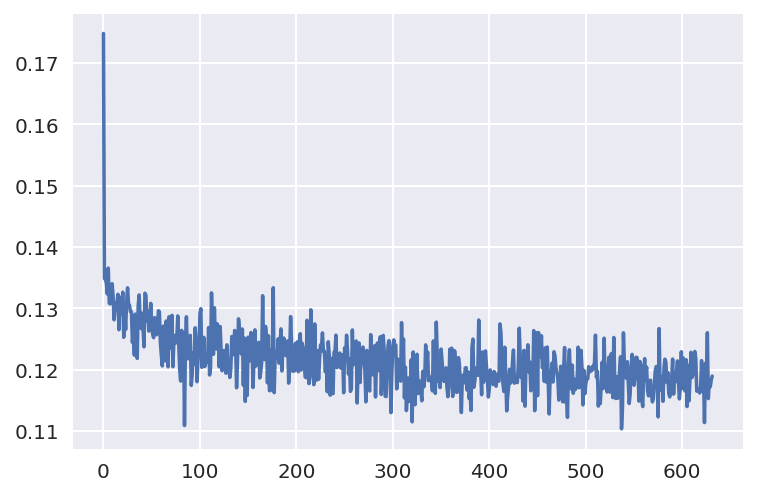

In [61]:
train_losses.plot()

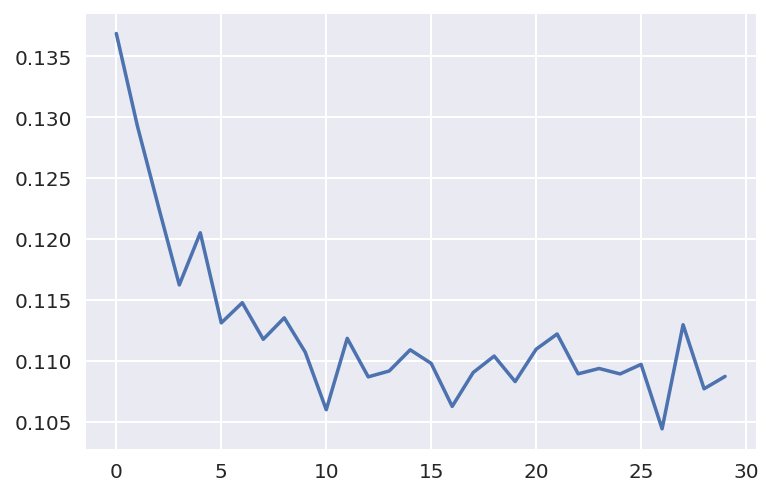

In [62]:
val_losses.plot()

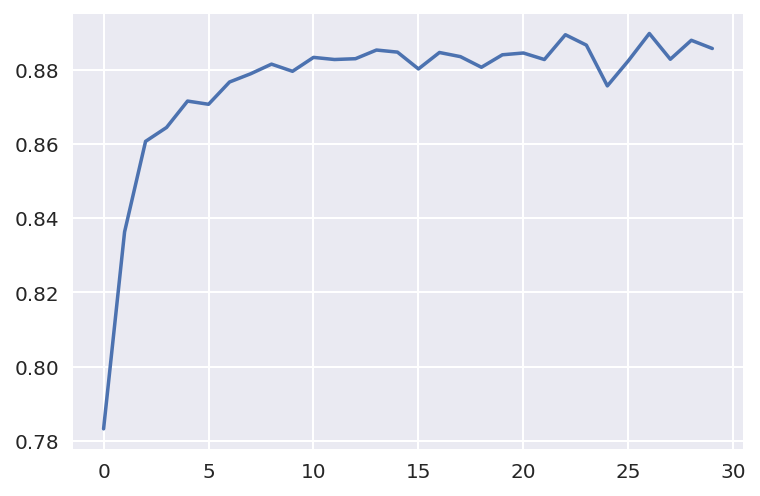

In [63]:
val_auc_scores.plot()

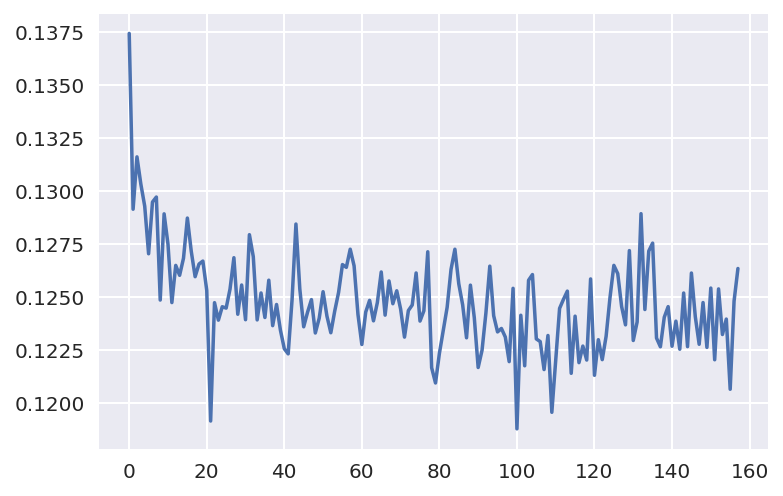

In [101]:
pd.Series(train_losses).plot()

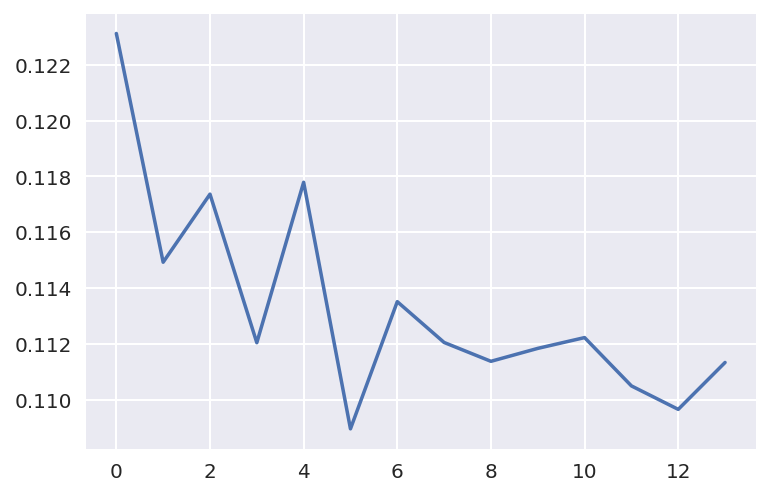

In [102]:
pd.Series(val_losses).plot()

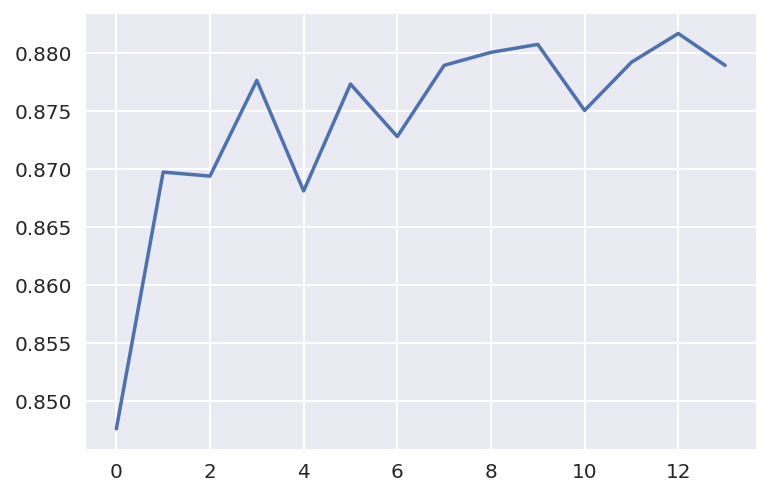

In [103]:
pd.Series(val_auc_scores).plot()

In [65]:
import torch
torch.save(model.state_dict(), NEURALNET/'StructuredNet.pkl')

In [ ]:
# Train ROC AUC Score: 0.821242
# Train Loss: 0.117414
# Validation ROC AUC Score: 0.888768
# Validation Loss: 0.107100
    
# Train ROC AUC Score: 0.826491
# Train Loss: 0.116814
# Validation ROC AUC Score: 0.881994
# Validation Loss: 0.109986

In [ ]:
# Train ROC AUC Score: 0.796762
# Train Loss: 0.119966
# Validation ROC AUC Score: 0.874341
# Validation Loss: 0.111939

# Train ROC AUC Score: 0.796169
# Train Loss: 0.119166
# Validation ROC AUC Score: 0.875377
# Validation Loss: 0.111252

In [ ]:
# Train ROC AUC Score: 0.792860
# Train Loss: 0.121061
# Validation ROC AUC Score: 0.872865
# Validation Loss: 0.117293
    
# Train ROC AUC Score: 0.794502
# Train Loss: 0.119734
# Validation ROC AUC Score: 0.875042
# Validation Loss: 0.112174

In [51]:
from src.structured_lstm import get_predictions

In [54]:
len(train_dl), len(val_dl)

(63303, 3857)

In [52]:
targets, preds = get_predictions(model, val_dl, USE_CUDA=USE_CUDA)

[0/493590 (0%)]
[153600/493590 (31%)]
[307200/493590 (62%)]
[460800/493590 (93%)]


In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(targets, preds)

0.8714340905872601

In [ ]:
targets, preds = get_predictions(model, train_dl, USE_CUDA=USE_CUDA)

In [ ]:
roc_auc_score(targets, preds)

## All datasets

In [95]:
%%time
train_ds = MultimodalDataset(train[cat_cols], train[num_cols],
                             train_seqs, train[target_col])
val_ds = MultimodalDataset(val[cat_cols], val[num_cols],
                             val_seqs, val[target_col])
test_ds = MultimodalDataset(test[cat_cols], test[num_cols],
                             test_seqs, test[target_col])

CPU times: user 3.33 s, sys: 4.24 s, total: 7.57 s
Wall time: 7.57 s


In [96]:
all_train_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])

In [97]:
%%time
all_train_dl = DataLoader(all_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128)

CPU times: user 0 ns, sys: 212 ms, total: 212 ms
Wall time: 209 ms


In [98]:
USE_CUDA = True

In [99]:
model = MultimodalNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5],
                      rnn_hidden_sz=64, rnn_input_sz=4, rnn_n_layers=2,
                      rnn_drop=0.5)

if USE_CUDA: model = model.cuda()

In [104]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [105]:
%%time
model, train_losses, _, _ = train_model(
                model, all_train_dl, None, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, print_every=800)

Train Epoch: 1 [102400/8596340 (1%)]	Loss: 0.149132
Train Epoch: 1 [204800/8596340 (2%)]	Loss: 0.134040
Train Epoch: 1 [307200/8596340 (4%)]	Loss: 0.132966
Train Epoch: 1 [409600/8596340 (5%)]	Loss: 0.131704
Train Epoch: 1 [512000/8596340 (6%)]	Loss: 0.132058
Train Epoch: 1 [614400/8596340 (7%)]	Loss: 0.126562
Train Epoch: 1 [716800/8596340 (8%)]	Loss: 0.128623
Train Epoch: 1 [819200/8596340 (10%)]	Loss: 0.129845
Train Epoch: 1 [921600/8596340 (11%)]	Loss: 0.126468
Train Epoch: 1 [1024000/8596340 (12%)]	Loss: 0.124746
Train Epoch: 1 [1126400/8596340 (13%)]	Loss: 0.124627
Train Epoch: 1 [1228800/8596340 (14%)]	Loss: 0.129204
Train Epoch: 1 [1331200/8596340 (15%)]	Loss: 0.127434
Train Epoch: 1 [1433600/8596340 (17%)]	Loss: 0.127579
Train Epoch: 1 [1536000/8596340 (18%)]	Loss: 0.126889
Train Epoch: 1 [1638400/8596340 (19%)]	Loss: 0.125576
Train Epoch: 1 [1740800/8596340 (20%)]	Loss: 0.122636
Train Epoch: 1 [1843200/8596340 (21%)]	Loss: 0.127469
Train Epoch: 1 [1945600/8596340 (23%)]	Loss:

In [116]:
%%time
model, train_losses, _, _ = train_model(
                model, all_train_dl, None, optimizer, criterion,
                n_epochs=1, USE_CUDA=USE_CUDA, print_every=800)

Train Epoch: 1 [102400/8596340 (1%)]	Loss: 0.117061
Train Epoch: 1 [204800/8596340 (2%)]	Loss: 0.114934
Train Epoch: 1 [307200/8596340 (4%)]	Loss: 0.114511
Train Epoch: 1 [409600/8596340 (5%)]	Loss: 0.113955
Train Epoch: 1 [512000/8596340 (6%)]	Loss: 0.120114
Train Epoch: 1 [614400/8596340 (7%)]	Loss: 0.115972
Train Epoch: 1 [716800/8596340 (8%)]	Loss: 0.117178
Train Epoch: 1 [819200/8596340 (10%)]	Loss: 0.115625
Train Epoch: 1 [921600/8596340 (11%)]	Loss: 0.114849
Train Epoch: 1 [1024000/8596340 (12%)]	Loss: 0.116056
Train Epoch: 1 [1126400/8596340 (13%)]	Loss: 0.115640
Train Epoch: 1 [1228800/8596340 (14%)]	Loss: 0.117489
Train Epoch: 1 [1331200/8596340 (15%)]	Loss: 0.116842
Train Epoch: 1 [1433600/8596340 (17%)]	Loss: 0.116462
Train Epoch: 1 [1536000/8596340 (18%)]	Loss: 0.116334
Train Epoch: 1 [1638400/8596340 (19%)]	Loss: 0.115166
Train Epoch: 1 [1740800/8596340 (20%)]	Loss: 0.116613
Train Epoch: 1 [1843200/8596340 (21%)]	Loss: 0.115511
Train Epoch: 1 [1945600/8596340 (23%)]	Loss:

KeyboardInterrupt: 

## Additional epoch

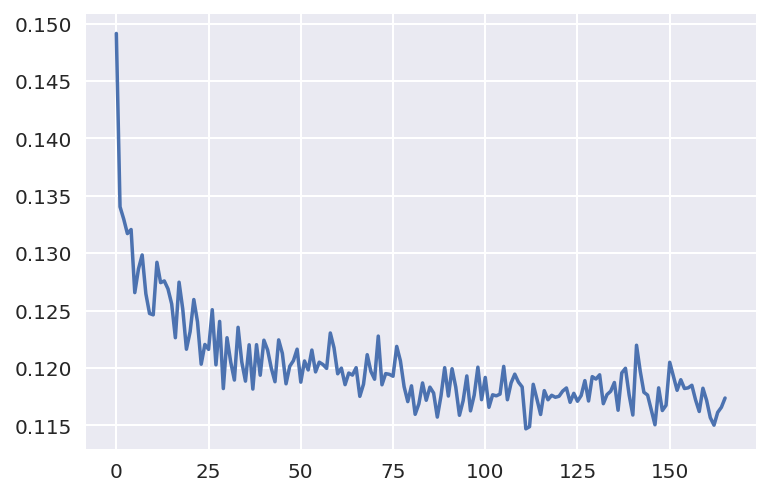

In [117]:
train_losses = pd.Series(train_losses)
train_losses.plot()

In [118]:
targets, preds = get_predictions(model, test_dl, USE_CUDA=True)

[0/484758 (0%)]
[153600/484758 (32%)]
[307200/484758 (63%)]
[460800/484758 (95%)]


In [119]:
test[target_col] = preds

In [120]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [121]:
submission.to_csv(SUBMISSIONS/'RA08-29-3_epochs_FinalStructuredLSTM_2018.csv', index=False)

## Final submission

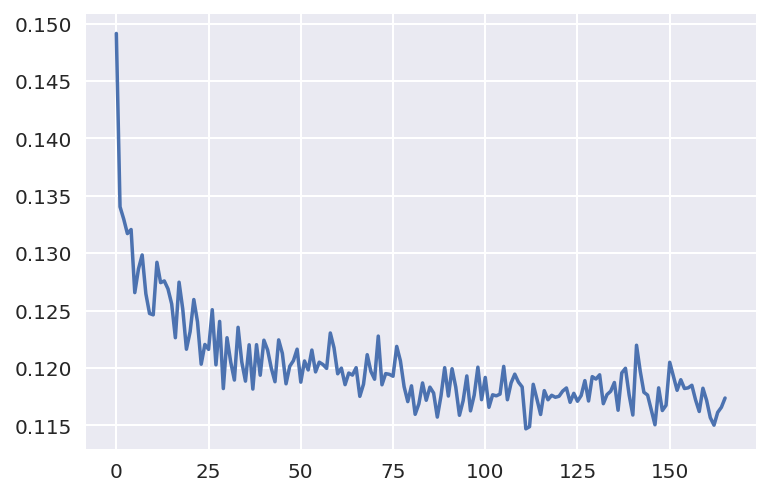

In [106]:
train_losses = pd.Series(train_losses)
train_losses.plot()

In [107]:
torch.save(model.state_dict(), NEURALNET/'AllTrain_FinalNet.pkl')

In [108]:
from src.structured_lstm import get_predictions

In [109]:
targets, preds = get_predictions(model, test_dl, USE_CUDA=True)

[0/484758 (0%)]
[153600/484758 (32%)]
[307200/484758 (63%)]
[460800/484758 (95%)]


In [110]:
test[target_col] = preds

In [115]:
len(test), len(preds), len(targets)

(484758, 484758, 484758)

In [113]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.041435
1,c2cc6cc2a8,0.046257
2,a8e94f6344,0.002685
3,758bae1e35,0.000578
4,02ab378ee8,0.001583


In [111]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

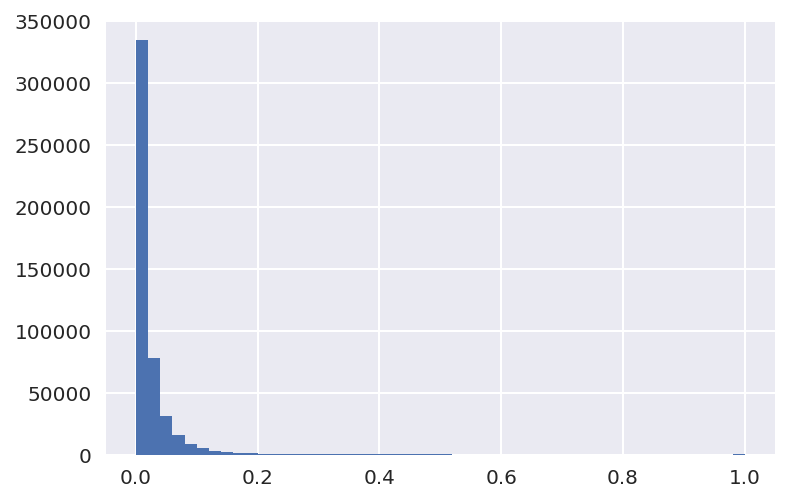

In [112]:
submission[target_col].hist(bins=50)

In [114]:
submission.to_csv(SUBMISSIONS/'RA07-30-FinalStructuredLSTM_2018.csv', index=False)

## Checkpoint

In [73]:
%%time
model, train_losses, _, _ = train_model(
                model, all_train_dl, None, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, print_every=800)

Train Epoch: 1 [25600/8596340 (0%)]	Loss: 0.174241
Train Epoch: 1 [51200/8596340 (1%)]	Loss: 0.138858
Train Epoch: 1 [76800/8596340 (1%)]	Loss: 0.135397
Train Epoch: 1 [102400/8596340 (1%)]	Loss: 0.136882
Train Epoch: 1 [128000/8596340 (1%)]	Loss: 0.126548
Train Epoch: 1 [153600/8596340 (2%)]	Loss: 0.130697
Train Epoch: 1 [179200/8596340 (2%)]	Loss: 0.133879
Train Epoch: 1 [204800/8596340 (2%)]	Loss: 0.125986
Train Epoch: 1 [230400/8596340 (3%)]	Loss: 0.134231
Train Epoch: 1 [256000/8596340 (3%)]	Loss: 0.131977
Train Epoch: 1 [281600/8596340 (3%)]	Loss: 0.126725
Train Epoch: 1 [307200/8596340 (4%)]	Loss: 0.131182
Train Epoch: 1 [332800/8596340 (4%)]	Loss: 0.132204
Train Epoch: 1 [358400/8596340 (4%)]	Loss: 0.126656
Train Epoch: 1 [384000/8596340 (4%)]	Loss: 0.127485
Train Epoch: 1 [409600/8596340 (5%)]	Loss: 0.124951
Train Epoch: 1 [435200/8596340 (5%)]	Loss: 0.135411
Train Epoch: 1 [460800/8596340 (5%)]	Loss: 0.132066
Train Epoch: 1 [486400/8596340 (6%)]	Loss: 0.135259
Train Epoch: 1 

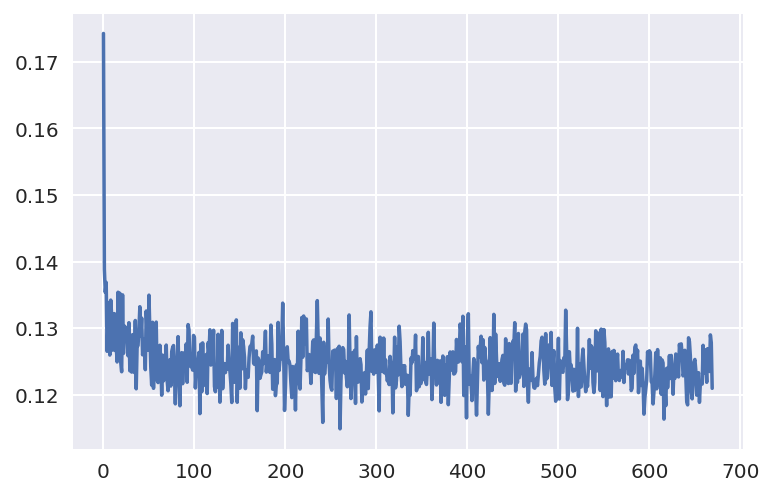

In [74]:
train_losses = pd.Series(train_losses)
train_losses.plot()

In [75]:
torch.save(model.state_dict(), NEURALNET/'AllTrain_StructuredNet.pkl')

In [78]:
from src.structured_lstm import get_predictions

In [79]:
targets, preds = get_predictions(model, test_dl, USE_CUDA=True)

[0/484758 (0%)]
[153600/484758 (32%)]
[307200/484758 (63%)]
[460800/484758 (95%)]


In [80]:
test[target_col] = preds

## Submission

In [81]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [82]:
submission[target_col].describe()

count    4.847580e+05
mean     1.851676e-02
std      3.054075e-02
min      8.888772e-09
25%      5.456142e-03
50%      9.974612e-03
75%      2.006161e-02
max      9.997458e-01
Name: CustomerInterest, dtype: float64

In [83]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.007760
1,c2cc6cc2a8,0.028238
2,a8e94f6344,0.005077
3,758bae1e35,0.001098
4,02ab378ee8,0.002522


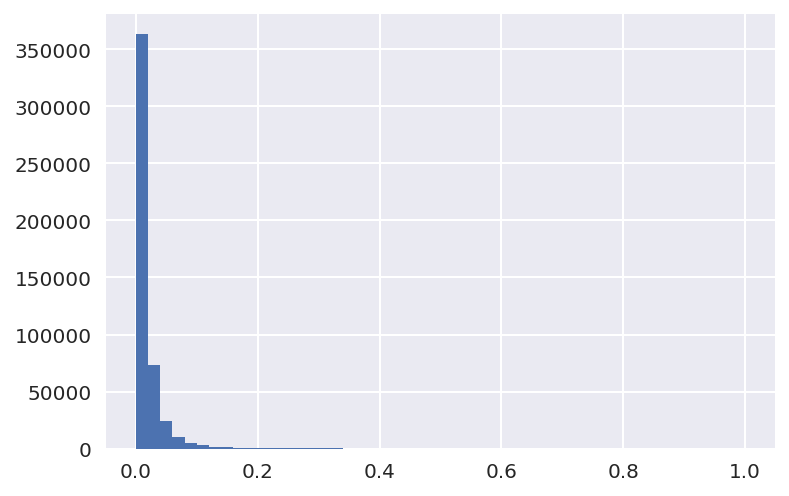

In [84]:
submission[target_col].hist(bins=50)

In [85]:
submission.to_csv(SUBMISSIONS/'RA06-29-StructuredLSTM_2018.csv', index=False)